# Data analysis of gas mileage in my rx8

First we load packages.

In [136]:
import MySQLdb as mdb
import sys
import pandas as pd
import pandas.io.sql
import numpy as np
from numpy import log
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Next we connect to the MySQL database and load the entire table as a pandas dataframe.

In [137]:
con = mdb.connect(host='localhost', db='mpg_db', read_default_file='~/.my.cnf')
gas_data = pd.read_sql("SELECT * FROM mpg_table", con)
con.close()

In [138]:
print(type(gas_data)) #shows type as pandas dataframe
print(gas_data) 
#list(gas_data) #shows some info about the fields in the table

<class 'pandas.core.frame.DataFrame'>
        thedate  days  odometer  miles  gallons   cost  costpergal   station  \
0    2014-04-09    12     15081  155.5   10.628  42.40       3.989    Costco   
1    2014-04-19    10     15275  194.4   12.253  50.96       4.159    Costco   
2    2014-04-24     5     15529  253.2   13.930  57.10       4.099    Costco   
3    2014-05-03     9     15700  171.1   10.310  41.95       4.069    Costco   
4    2014-05-13    10     15897  197.5   12.917  52.17       4.039    Costco   
5    2014-05-24    11     16093  195.7   13.366  53.05       3.969    Costco   
6    2014-06-04    10     16286  191.8   12.660  49.99       3.949    Costco   
7    2014-06-09     5     16518  232.0   12.719  50.23       3.949    Costco   
8    2014-06-15     6     16700  181.9   11.156  44.06       3.949    Costco   
9    2014-06-21     6     16924  224.4   13.062  52.33       3.999    Costco   
10   2014-06-28     7     17059  134.4    8.771  35.51       4.049    Costco   
11

Here's an example of using the dataframe to get the mean of the mpg column.

In [139]:
print(np.mean(gas_data['mpg']))

14.4248207018


Now we plot the mileage over time.

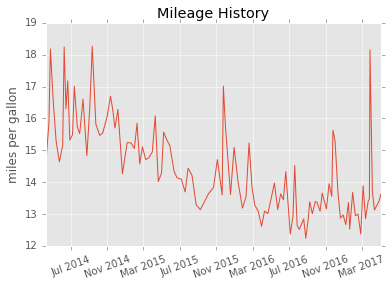

In [140]:
plt.plot_date(matplotlib.dates.date2num(gas_data['thedate']), 
                         gas_data['mpg'], '-') #time-mpg
plt.title('Mileage History')
plt.ylabel('miles per gallon')
plt.xticks(rotation=20)
plt.show()

Here's a plot of gas prices over time, coded by the station used.

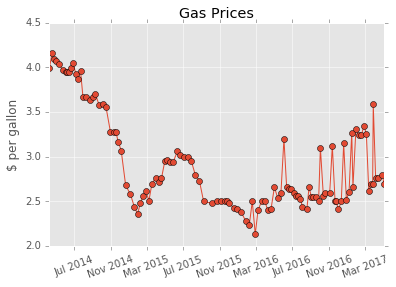

In [141]:
plt.plot_date(matplotlib.dates.date2num(gas_data['thedate']), 
                         gas_data['costpergal'], '-o') #time-mpg
plt.title('Gas Prices')
plt.ylabel('$ per gallon')
plt.xticks(rotation=20)
plt.show()

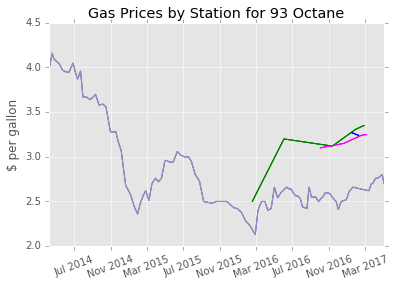

In [214]:
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Costco'].thedate), 
              gas_data[gas_data.station=='Costco'].costpergal, '-')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='BP'].thedate), 
              gas_data[gas_data.station=='BP'].costpergal, 'green')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Marathon'].thedate), 
              gas_data[gas_data.station=='Marathon'].costpergal, 'blue')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Mobil'].thedate), 
              gas_data[gas_data.station=='Mobil'].costpergal, 'magenta')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Sunoco'].thedate), 
              gas_data[gas_data.station=='Sunoco'].costpergal, 'orange')
              
#gas_data[gas_data.station=='BP'].plot(x='thedate', y='costpergal', color='blue') 
#pandas wrapper
plt.xticks(rotation=20)
plt.title('Gas Prices by Station for 93 Octane')
plt.ylabel('$ per gallon')
plt.show()

The following is a plot of mileage given the number of miles driven per day. The MpD is used as an indicator of highway driving, and we expect highway driving to produce better MpG.

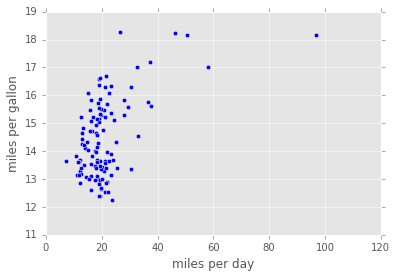

In [142]:
plt.scatter(gas_data['mpd'], gas_data['mpg']) #mpd-mpg
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.show()

Here we make a boxplot of the overall mileage.

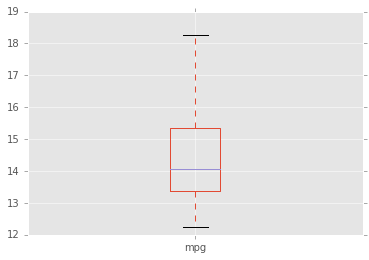

In [143]:
gas_data['mpg'].plot.box() #pandas wrapper of matplotlib?
#plt.boxplot(gas_data['mpg']) #alternative
plt.show()

Now let's make two boxplots grouped by what looks like city mileage and highway mileage.

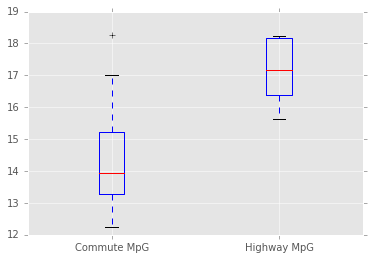

2     18.17660
7     18.24043
9     17.17960
55    17.00989
56    15.74346
93    15.63083
Name: mpg, dtype: float64

In [198]:
cutoff=35 #set cutoff between two groups
#fig = plt.figure()
#ax = fig.add_subplot(111)
plt.boxplot([gas_data[gas_data.mpd<cutoff].mpg,gas_data[gas_data.mpd>=cutoff].mpg])
plt.xticks([1, 2], ['Commute MpG', 'Highway MpG'])
plt.show()
#gas_data[(gas_data.mpd>cutoff) & (gas_data.station=='Costco')].mpg
#above shows how t select multiple conditions

New tires were put on after the December 6th, 2014 fill up. These tires had a stickier compund which reduced the mileage.

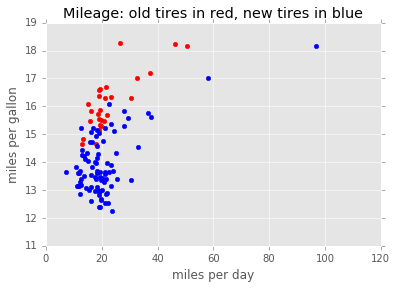

In [145]:
from datetime import datetime
#gas_data[gas_data.thedate<datetime.strptime('2014-12-07','%Y-%m-%d').date()].mpd
#also consider num2date from matplotlib
plt.scatter(gas_data[gas_data.thedate<datetime.strptime('2014-12-07','%Y-%m-%d').date()].mpd, 
            gas_data[gas_data.thedate<datetime.strptime('2014-12-07','%Y-%m-%d').date()].mpg, 
            color='red') #mpd-mpg
plt.scatter(gas_data[gas_data.thedate>datetime.strptime('2014-12-07','%Y-%m-%d').date()].mpd, 
            gas_data[gas_data.thedate>datetime.strptime('2014-12-07','%Y-%m-%d').date()].mpg, 
            color='blue') #mpd-mpg
plt.title('Mileage: old tires in red, new tires in blue')
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.show()

Let's look at box plots comparing the old and new tires now.

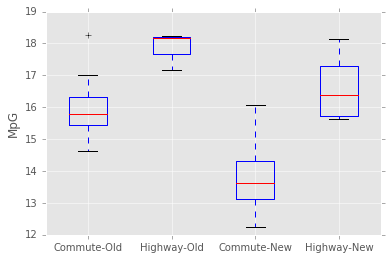

In [211]:
cutoff=35 #set cutoff between two groups

plt.boxplot([gas_data[(gas_data.mpd<cutoff) & (gas_data.thedate<datetime.strptime('2014-12-07','%Y-%m-%d').date())].mpg, 
             gas_data[(gas_data.mpd>=cutoff) & (gas_data.thedate<datetime.strptime('2014-12-07','%Y-%m-%d').date())].mpg, 
             gas_data[(gas_data.mpd<cutoff) & (gas_data.thedate>datetime.strptime('2014-12-07','%Y-%m-%d').date())].mpg,
             gas_data[(gas_data.mpd>=cutoff) & (gas_data.thedate>datetime.strptime('2014-12-07','%Y-%m-%d').date())].mpg
            ])
plt.xticks([1, 2, 3, 4], ['Commute-Old', 'Highway-Old', 'Commute-New', 'Highway-New'])
plt.ylabel('MpG')
plt.show()
##gas_data[(gas_data.mpd>cutoff) & (gas_data.station=='Costco')].mpg
##gas_data[(gas_data.mpd>cutoff) & (gas_data.thedate<datetime.strptime('2014-12-07','%Y-%m-%d').date())].mpg

## Regression analysis

Here we run a linear regression using the statsmodel library.

In [146]:
regression2 = smf.ols(formula = 'mpg ~ mpd', data = gas_data).fit()
print(regression2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     44.47
Date:                Tue, 09 May 2017   Prob (F-statistic):           1.02e-09
Time:                        19:16:09   Log-Likelihood:                -182.15
No. Observations:                 114   AIC:                             368.3
Df Residuals:                     112   BIC:                             373.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9140      0.253     51.011      0.0

Here's an alternative method to get some regression data using the scikit library.

In [147]:
mpg_data2 = gas_data[['mpg']]
mpd_data2 = gas_data[['mpd']]
sk_regr = linear_model.LinearRegression()
sk_regr.fit(mpd_data2, mpg_data2)
print(sk_regr.coef_)
print(sk_regr.intercept_)
print(sk_regr.score(mpd_data2, mpg_data2))

[[ 0.07233263]]
[ 12.91403625]
0.28422390979


We can see the data matches up with both methods. This linear model isn't a great fit, as indicated by the R-squared value.

We can also try a log model, however the fit appears to be even worse.

In [148]:
gas_data['log_mpd'] = log(gas_data['mpd'])
gas_data['log_mpg'] = log(gas_data['mpg'])
log_lm = smf.ols(formula = 'log_mpg ~ log_mpd', data = gas_data).fit()
print(log_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                log_mpg   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     36.40
Date:                Tue, 09 May 2017   Prob (F-statistic):           2.12e-08
Time:                        19:16:09   Log-Likelihood:                 122.19
No. Observations:                 114   AIC:                            -240.4
Df Residuals:                     112   BIC:                            -234.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2722      0.065     34.708      0.0

# Summary of process and tools used

1. Gas data recorded in spreadsheet, and exported as csv file
2. Csv file loaded into local MySQL database
3. Run Python through Jupyter Notebook
4. Connect to MySQL database using Python
5. Perform data analysis and visualization in Python
6. Control versions and save to Github using Git
7. Using Mac OSX with bash shell